# **Bars:**

In order to apply Ml algorithm on your unstructured dataz, we need to parse it, extract valuable information from it, and store those extractions in a regular sized format.

The purpose of using advanced bar methods is to transform a series of observations that arrive at irregular frequency "inhommogenous series" into "homogenous" series derived from regular sampling.

**Time bars** are obtained by sampling information at fixed interval (for instance, every minute) and the information collected usually includes:

* Timestamp
* Volume
* Open price 
* Close price
* High price
* Low price
* Volume-weigthed average price

Although time bars are very popular among practioners, they should be avoid because :



1.   market do not process inforation at constant interval (more active at the opening and the closure)
2.   Time-sampled series show poor statistical properties (non-normal returns, heteroscedasticity, serial correlation)

**Tick bars:**

The sample variables, named upper, are extracted each time a pre-defined number of transactions takes  place, so that, it synchronizes the sampling with a proxy of information arrival.

Indeed, sampling allows us to achieve returns closer to IID normal distribution.

One drawback is the arbitrariness in the number of ticks chosen.

**Volume bars:**

Volume bars tacles the issue raised by the arbitrariness introduced by tick bars by sampling a pre-defined amount of security's units have been exchanged

**Dollar bars:**

Dollar bars are formed by sampling an observation every time a pre-defined market value is exchanged. It could be in any currency let's be clear. In that way, the number of shares traded is function of the actual value exchanged.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime


### **Import dataset**

In [2]:
# read tick data from http://www.kibot.com/support.aspx#data_format

def read_kibot_ticks(fp):   
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header=None)
          .rename(columns=dict(zip(range(len(cols)),cols)))
          .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')))
          .assign(v=lambda df: df['size']) # volume
          .assign(dv=lambda df: df['price']*df['size']) # dollar volume
          .drop(['date','time'],axis=1)
          .set_index('dates')
          .drop_duplicates())
    return df
    

In [3]:
# import data file afteer mounting your drive (my data file is on the drive) and create the data frame 

df = read_kibot_ticks("/content/drive/MyDrive/Colab Notebooks/Advances_in_financial_machine_learning/IVE_tickbidask.txt")
df.head()

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


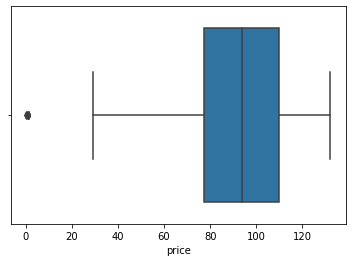

In [4]:

sns.boxplot(df.price)

On this box plot, we can clearly see outliers. Our frist is to take care of them.

### **Outliers detection and correction:**

How? while calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [5]:
def outliers_detection(y):
  z = np.abs(stats.zscore(y))
  threshold = 3
  return np.where(z > threshold)

In [6]:
outliers = outliers_detection(df.price.values.reshape(-1,1))
df.iloc[outliers[0]]

,price,bid,ask,size,v,dv
dates,,,,,,
2010-05-06 14:49:07,0.11,0.10,44.03,500,500,55.0
2010-05-06 14:53:30,1.10,1.10,30.28,2600,2600,2860.0
2010-05-06 14:55:32,1.10,1.10,50.57,300,300,330.0
2010-05-06 14:55:32,1.10,1.10,50.57,100,100,110.0
2010-05-06 14:55:32,1.10,1.00,50.57,200,200,220.0
2010-05-06 14:55:32,1.10,1.00,50.57,700,700,770.0
2010-05-06 14:55:32,1.10,1.00,50.57,1200,1200,1320.0
2010-05-06 14:55:32,1.10,0.55,50.57,500,500,550.0
2010-05-06 14:55:32,1.10,0.55,50.57,100,100,110.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


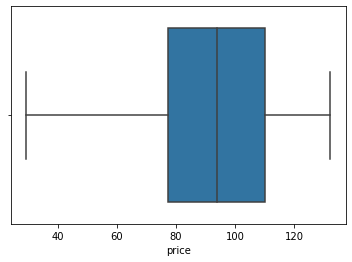

In [7]:
indexes_to_keep = set(range(df.shape[0])) - set(outliers[0])
df_sliced = df.take(list(indexes_to_keep))
sns.boxplot(df_sliced.price)

When constructing tick bars, you need to be aware of outliers. Many exchanges carry out auction at the open and an auction at the close. This means that for a period of time , the order book accumulates bids and offers without matching them.

It results in a large trade at the end of the auction at the clearing price. Becareful it could represents lots of ticks but be reported as one tick...

By synchronizing sampling with the arrival of informed traders , we may be able to make decisionsbefore prices reach a new equilibrium level.

### **Tick, volume and dollar bars:**

In [8]:
total_ticks = len(df)
print(f'num ticks: {total_ticks:,}')

volume_ratio = (df.v.sum()/total_ticks).round()
dollar_ratio = (df.dv.sum()/total_ticks).round()
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

num ticks: 2,005,379
volume ratio: 542.0
dollar ratio: 49997.0


In [9]:
start_date =datetime.strptime('2014-07-10', '%Y-%m-%d') #yyy-mm-dd
end_date =datetime.strptime('2014-08-10', '%Y-%m-%d') #yyy-mm-dd

date = '2014-07-10'

#### Tick bars:

In [10]:
# compute tick bars for the data frame
def tick_bars(df,M):
    '''
    # args
        df: pd.DataFrame()
        M: threshold value for ticks determined in the cell upper
    # returns
        idx: list of indices (where to sample)
    '''

    price = df['price']
    tc = 0 #tick counter
    idx = []

    for i,x in enumerate(tqdm(price)):
        tc += 1
        if tc >= M:
            idx.append(i)
            tc = 0
            continue

    return df.iloc[idx].drop_duplicates()

In [11]:
tbdf = tick_bars(df,100)

100%|██████████| 2005379/2005379 [00:00<00:00, 2532581.50it/s]


#### Volume bars:

In [12]:
# compute tick bars for the data frame
def volume_bars(df,M):
    '''
    # args
        df: pd.DataFrame()
        M: threshold volume making  a bar
    # returns
        dataframe composed of the volume bars
    '''

    volume = df['v']
    tc = 0 #tick counter
    idx = []

    for i,x in enumerate(tqdm(volume)):
        tc += x
        if tc >= M:
            idx.append(i)
            tc = 0
            continue

    return df.iloc[idx].drop_duplicates()

In [13]:
vbdf = volume_bars(df,10000)
print(vbdf.shape)
print(df.shape)

100%|██████████| 2005379/2005379 [00:00<00:00, 2254154.84it/s]


(81837, 6)
(2005379, 6)


#### Dollar bars:


In [14]:
# compute tick bars for the data frame
def dollar_bars(df,M):

    dollar_value = df['dv']
    tc = 0 #tick counter
    idx = []

    for i,x in enumerate(tqdm(dollar_value)):
        tc += x
        if tc >= M:
            idx.append(i)
            tc = 0
            continue

    return df.iloc[idx].drop_duplicates()

In [15]:
dbdf = dollar_bars(df,1e6)
print(dbdf.shape)
print(df.shape)

100%|██████████| 2005379/2005379 [00:00<00:00, 2466497.73it/s]

(74503, 6)
(2005379, 6)


#### Visualization:

In [16]:
def data_sample_day(df, bars_df, name, date): #name = 'price' in this example

    sample_df = pd.DataFrame()
    sample_bars_df = pd.DataFrame()

    sample_df[name] = df[name].loc[date]
    sample_bars_df[name] = bars_df[name].loc[date]

    return sample_df, sample_bars_df

In [17]:
def plot_data_sample(sampled_df, sampled_bars_df, bar_type, *args, **kwds):

    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    sampled_df.plot(*args, **kwds, ax=axes[0], label='price')
    sampled_bars_df.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    sampled_df.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sampled_bars_df.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return



##### Tick:

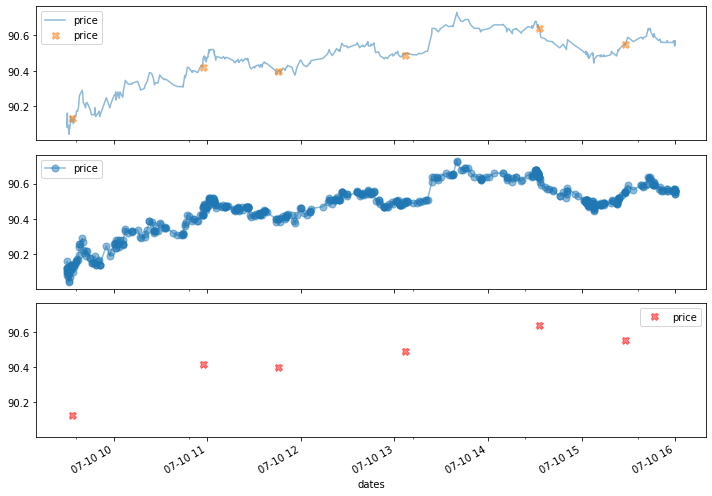

In [18]:
# tick bars
sdf, stbdf = data_sample_day(df, tbdf,'price',date)
plot_data_sample(sdf, stbdf, 'tick bar', alpha=0.5, markersize=7)

##### Volume:

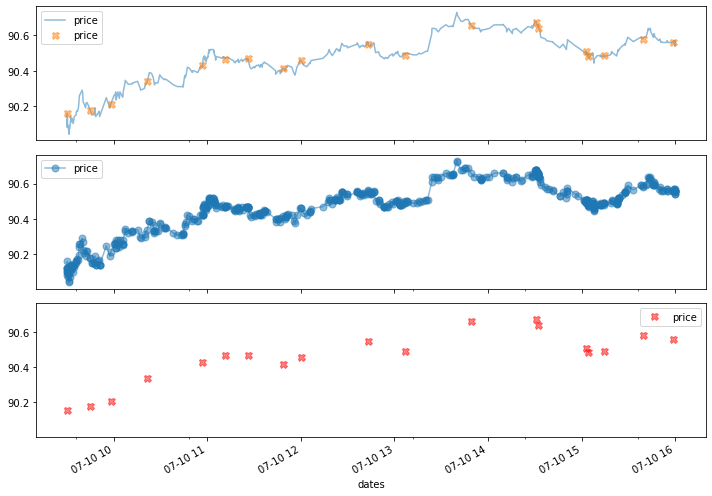

In [19]:
# volume bars
sdf, svbdf = data_sample_day(df, vbdf,'price', date)
plot_data_sample(sdf, svbdf, 'volume bar', alpha=0.5, markersize=7)

##### Dollar value:

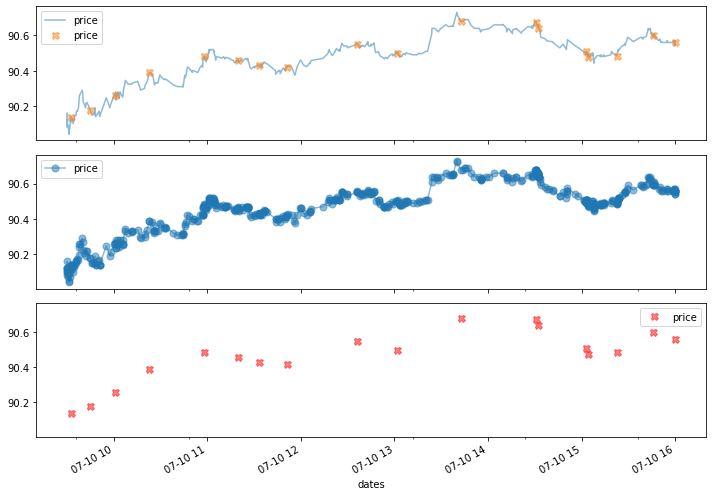

In [20]:
# volume bars
sdf, sdbdf = data_sample_day(df, dbdf,'price', date)
plot_data_sample(sdf, sdbdf, 'dollar bar', alpha=0.5, markersize=7)

#### **Conclusion**

Visually, I would said that dollar value and volume bar gives a better sampling (just enough of what we need).

It could be interesting to count the number of bar on regular basis (weekly, monthly) as well study taking a look at the standard deviation of these results over the time frame.



# **Contribution to risk per principal component analysis:**

The method presented in this section aimes at computing hedging weights for a portfolio of assets.

In the litterature, assets' weight are embeded into a vector $w_{t}$.
Let's consider an IID multivariate gaussian process characterized by a vectors of means $µ$ (Nx1) and a covariance matrix V (NxN).
This stochastic processs describes an invariant random variable such as stock returns, changes in the yield of a bond etc .... for a portfolio of N instruments.

Here, the goal is to compute the vector allocation $w$ that match a particular distribution of risk across V's principal components.

What is the process?


1.   Perform a spectral decomposition: $VW = W \Lambda$
2.   Compute the portfolio risk: $\sigma^2 = w'Vw = w'W \Lambda W'= \beta^{'}\Lambda \beta$, where beta represents the projection of $w$ on the orthogonal axis.
3. Compute the distribution of risk accross the orthgonal components R (1xN) with $R_{n}= \beta^2\Lambda_{n,n}\sigma^{-2} = [W'w]_{n}^2\Lambda_{n,n}\sigma^{-2}$ and $R_{n}^{'}x1_{n} =1$.
4. Compute w that delivers a user-specifc riskdistribution R. Notice that $\beta=\sigma\sqrt{\frac{R_{n}}{\lambda_{n,n}}}$ (1xN).
5. The allocation is given by : $w=W\beta$ 



In [21]:
def pca_weights(cov, riskDist=None, riskTarget=1):
    eVal, eVec = np.linalg.eigh(cov) # must be hermitian
    indices = eVal.argsort()[::-1] # descending order
    eVal, eVec = eVal[indices], eVec[:, indices]

    if riskDist is None:
      riskDist=np.zeros(cov.shape[0])
      riskDist[-1]=1
    loads=riskTarget*(riskDist/eVal)**0.5
    wghts = np.dot(eVec,np.reshape(loads,(-1,1)))

    return wghts

# **Sampling features:**

Although you could attempt to attempt to apply ML algorithm on a strucured dataset , in general that would not be a good idea for a couple of reasons:



1.   ML algorithm do not scale well with sample size
2.   ML algorithm get better accuracy when they learn from relevant examples

one reason for sampling features from strucutred dataset is to reduce the amount of data used (downsampling).

What method should we used ?

Tipically, portfolio managers place a bet after some event takes place (structural break, exracted signal, microstructural phenomenon).
These events could be associated with the release of some macroeconomic statisitcs, a spike in volatility, a signfiant departure in  a spread away from its equilibrium level etc...

We can characterize an event as signifiant, and let the ML algorithm learn wether there is an accurate prediction function under those circumstances. If no the defintion of the event should be revised.

The CUMSUM FILTER is a quality control method designed to detect a shift in the mean value of a measured quantity away from a target value.

One practial aspect that makes CUMSUM filter appealing is that multiple events are not  triggered by the raw data hovering around a threshold level. Indeed, it will require a full run of length h to trigger an event.


In [22]:
def getTEvents(gRaw,h): # Credit Marco Lopez de Prado
  tEvents,sPos, sNeg=[], 0, 0
  diff = gRaw.diff()
  for i in diff.index[1:]:
    sPos, sNeg = max(0,sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
    if sNeg <- h:
      sNeg=0; tEvents.append(i)
    elif sPos>h:
      sPos=0; tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

#### Bollinger Bands:

In [23]:
def bollingerBands(dataframe, nb_std):

  dataframe['MA20'] = dataframe['price'].rolling(window=20).mean()
  dataframe['20dSTD'] = dataframe['price'].rolling(window=20).std() 

  dataframe['Upper'] = dataframe['MA20'] + dataframe['20dSTD'] * nb_std
  dataframe['Lower'] = dataframe['MA20'] - dataframe['20dSTD'] * nb_std

  return dataframe

In [30]:
bolinger_dbdf = bollingerBands(dbdf, 2)

In [48]:
def dataframe_sample_period(bars_df, startDate, endDate): #name = 'price' in this example
    
    sample_bars_df = pd.DataFrame()

    #greater than the start date and smaller than the end date
    mask = (bars_df.index > startDate) & (bars_df.index<= endDate)
     
    sample_bars_df['price'] = bars_df['price'].loc[mask]
    sample_bars_df['MA20'] = bars_df['MA20'].loc[mask]
    sample_bars_df['Upper'] = bars_df['Upper'].loc[mask]
    sample_bars_df['Lower'] = bars_df['Lower'].loc[mask]

    return sample_bars_df

In [49]:
sample_dbdf = dataframe_sample_period(dbdf,'2014-07-10', '2014-08-10')

In [67]:
def plot_bollinger_bands(dataframe):
  dataframe[['price','MA20','Upper','Lower']].plot(figsize=(10,4))
  plt.grid(True)

  crosses_up = ((dataframe['price'] > dataframe['Upper']) & ~(dataframe['price'].shift(1) > dataframe['Upper'].shift(1)))
  crosses_down = (( dataframe['price'] < dataframe['Lower']) & ~(dataframe['price'].shift(1) < dataframe['Lower'].shift(1)))
  print("Crosses up & out:", crosses_up.sum())
  print("Crosses down & out:", crosses_down.sum())
  (crosses_up.astype(float) * 1 + 85).plot(color='tab:green')
  (crosses_down.astype(float) * 1 + 85).plot(color='tab:red', title='Bollinger Band crosses');

  plt.title( ' Bollinger Bands')
  plt.axis('tight')
  plt.ylabel('Price')
  plt.plot()



Crosses up & out: 8
Crosses down & out: 19


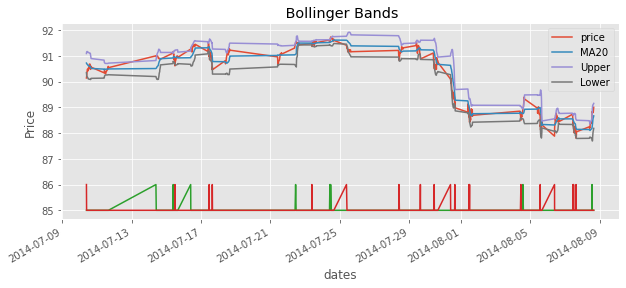

In [68]:
plot_bollinger_bands(sample_dbdf)